# Respiratory, Blood Pulse Volume, Electro Dermal Activity - Solution

The goal of this lab is the analysis of various biological signals using bitalino sensors and data processing using python code. 

In particular, in this experience we will focus on manipulating data related to respiration, heartbeats and eletrodermal activity. 

### Data analysis

First step is to load the needed packages:

In [27]:
# biosignalsnotebooks Python package with useful functions that support and complement the available Notebooks
import biosignalsnotebooks as bsnb
import math
import numpy as np
import matplotlib.pyplot as plt
from h5py import File
from scipy import signal

# Pacakge dedicated to Wavelet decomposition algorithms.
from pywt import swt, iswt

# Deep copy function to clone lists.
from copy import deepcopy

Import the recorded signal by entering the absolute path. 

In [2]:
file_path = "C://Users//smarocco.inst//Desktop//SUPSI//WORK//LAB BioSgn//Respiro.h5"
h5_object = File(file_path)

The objects we are going to analyze are files of type .h5.

Let us proceed to analyze the composition of the file in a hierarchical manner:

In [3]:
# Keys list (.h5 hierarchy ground level)
print(list(h5_object.keys()))

['84:BA:20:AE:BC:90']


In [4]:
h5_group = h5_object.get('84:BA:20:AE:BC:90')
print ("Second hierarchy level: " + str(list(h5_group)))

Second hierarchy level: ['digital', 'events', 'plugin', 'raw', 'support']


In [5]:
print ("Metadata of h5_group: \n" + str(list(h5_group.attrs.keys())))

Metadata of h5_group: 
['channels', 'comments', 'date', 'device', 'device connection', 'device name', 'digital IO', 'duration', 'firmware version', 'keywords', 'macaddress', 'mode', 'nsamples', 'resolution', 'sampling rate', 'sync interval', 'time']


In [6]:
sampling_rate = h5_group.attrs.get("sampling rate")
print ("Sampling Rate: " + str(sampling_rate))
Resolution = h5_group.attrs.get("resolution")
Resolution

Sampling Rate: 1000


array([ 4,  1,  1,  1,  1, 10, 10, 10, 10,  6,  6])

For this experiment we are interested in manipulating data from sensors, so we are going to modify the "raw" data.  We therefore access the third hierarchical level of the data format. 

In [7]:
h5_sub_group = h5_group.get("raw")
print("Third hierarchy level: " + str(list(h5_sub_group)))

Third hierarchy level: ['channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'nSeq']


From here the recorded data for each sensor channel can be accessed. In our case we will use the data recorded on channel 1 

To facilitate data manipulation operations we transform a nested list to a flatten list. We then generate the signal reference time using the function bsnb.generate_time(). 

In [8]:
h5_data = h5_sub_group.get("channel_1")
signal = [item for sublist in h5_data for item in sublist]
time = bsnb.generate_time(signal, sampling_rate)

Use a plot to visualize the raw data from the signal

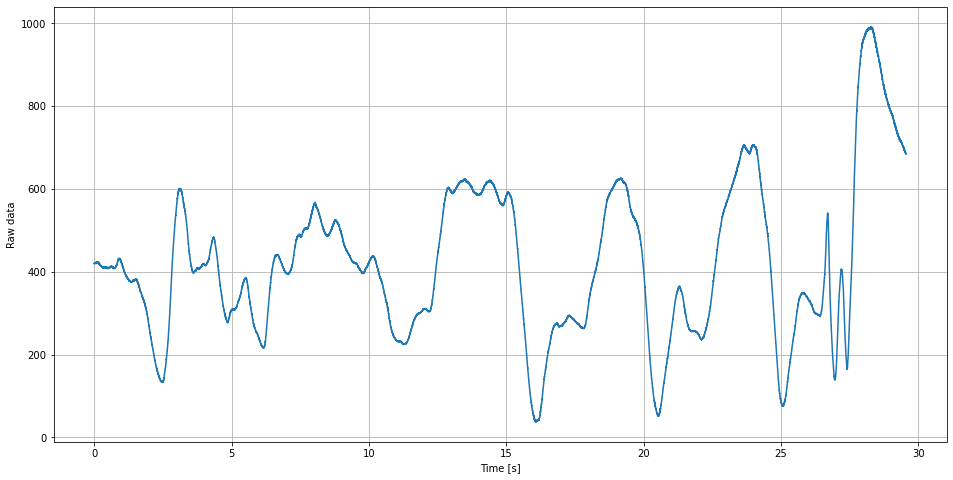

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(time, signal)
plt.ylabel("Raw data")
plt.xlabel("Time [s]")
plt.grid()

It is now needed to convert the raw EEG signal to its physical units, to do this we have to use the transfer function of the EEG sensor:

$$ PZT(V) = \frac{(\frac{ADC}{2^n - 1}-0.5) \cdot VCC}{G_{PZT}}$$

Where
- VCC = 3V
- G = 1
- ADC = Value sampled from the channel
- n = Number of bits of the channel

In [10]:
gain = 1
signal_V = ((np.array(signal) / 2**Resolution[6]) - 0.5) * 3000

Generate the time reference for the signal expressed in volts:

In [11]:
time = bsnb.generate_time(signal_V, sampling_rate)

Use a plot to visualize the signal converted in Volts

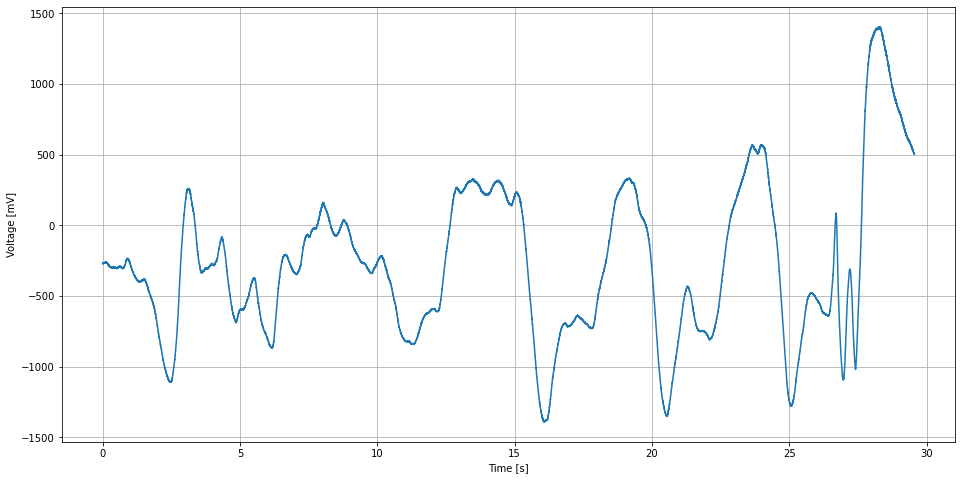

In [12]:
plt.figure(figsize=(16, 8))
plt.plot(time, signal_V)
plt.ylabel("Voltage [mV]")
plt.xlabel("Time [s]")
plt.grid()

## Blood Volume Pulse (BVP)

The pulse sensor included in the PsychoBIT kit shown in the figure is used for this part of the experiment. 

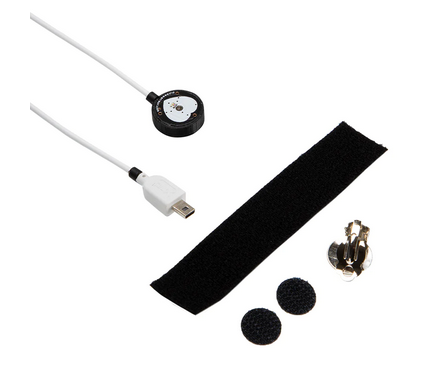

Connect the sensor to input A1 of the PsychoBIT and repeat the points of the experiment on the PZT starting at point 2. 

Import the recorded signal by entering the absolute path.

In [13]:
file_path = "C://Users//smarocco.inst//Desktop//SUPSI//WORK//LAB BioSgn//BPM.h5"
h5_object_BPM = File(file_path)

In [14]:
# Keys list (.h5 hierarchy ground level)
print(list(h5_object_BPM.keys()))

['84:BA:20:AE:BC:90']


In [15]:
h5_group_BPM = h5_object_BPM.get('84:BA:20:AE:BC:90')
print ("Second hierarchy level: " + str(list(h5_group_BPM)))

Second hierarchy level: ['digital', 'events', 'plugin', 'raw', 'support']


In [16]:
print ("Second hierarchy level: " + str(list(h5_group_BPM)))

Second hierarchy level: ['digital', 'events', 'plugin', 'raw', 'support']


In [17]:
sampling_rate_BPM = h5_group_BPM.attrs.get("sampling rate")
print ("Sampling Rate: " + str(sampling_rate_BPM))

Sampling Rate: 1000


In [18]:
h5_sub_group_BPM = h5_group_BPM.get("raw")
print("Third hierarchy level: " + str(list(h5_sub_group_BPM)))

Third hierarchy level: ['channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'nSeq']


In [19]:
h5_data_BPM = h5_sub_group_BPM.get("channel_1")
signal_BPM = [item for sublist in h5_data_BPM for item in sublist]
time_BPM = bsnb.generate_time(signal_BPM, sampling_rate_BPM)

Plot the raw signal recorded by the sensor:

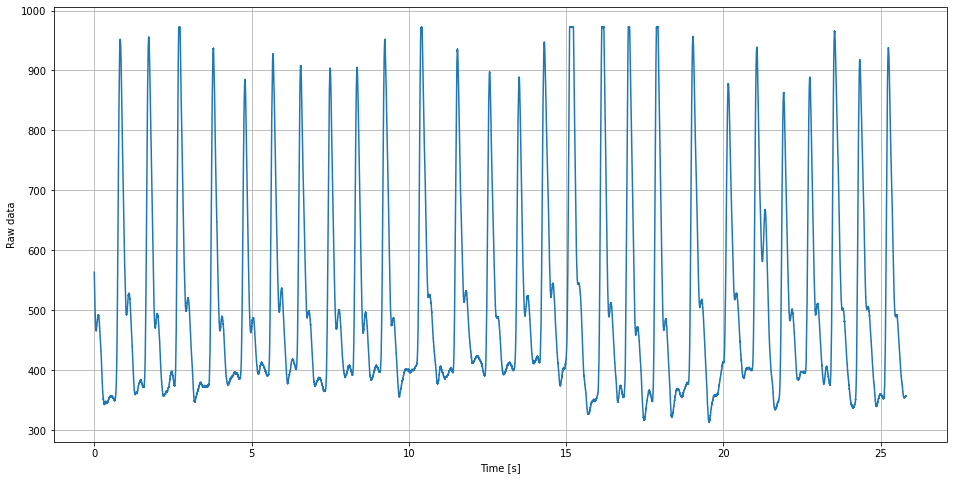

In [20]:
plt.figure(figsize=(16, 8))
plt.plot(time_BPM, signal_BPM)
plt.ylabel("Raw data")
plt.xlabel("Time [s]")
plt.grid()

To attenuate all signal components outside the typical BVP frequency bands it will be used a conventional bandpass filter, intended 
To compare the influence of multiple filter bandpass frequencies it will be analysed a restrictive range - [0.02; 2.1] Hz - and a more extended option - [0.6875; 10] Hz

Initialize the filters data:

In [21]:
#RES filter data
cutoff_H_res = 2.1
cutoff_L_res = 0.02

#EXT filter data
cutoff_H_ext = 10
cutoff_L_ext = 0.6875

In [22]:
# Filter requirements.
fs = 1000.0       # sample rate, Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2 

Definition of a second-order digital Butterworth filter:

In [28]:
def butter_bandpass_filter(data, cutoff_L, cutoff_H, fs, order):
    normal_cutoff = [cutoff_L / nyq, cutoff_H / nyq]
    # Get the filter coefficients 
    b, a = signal.butter(order, normal_cutoff, btype='bandpass', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

Apply the filter, with the right cut-off frequencies, to the signal:

In [29]:
signal_res = butter_bandpass_filter(signal_BPM, cutoff_L_res, cutoff_H_res, 1000, 2)
signal_ext = butter_bandpass_filter(signal_BPM, cutoff_L_ext, cutoff_H_ext, 1000, 2)

Plot the raw signal, the filtered signal between 0.02-2.1Hz and the filtered signal between 0.6875-10Hz.  

To better visualise the effect of filtering, limit the x-axis between 0 and 5s.

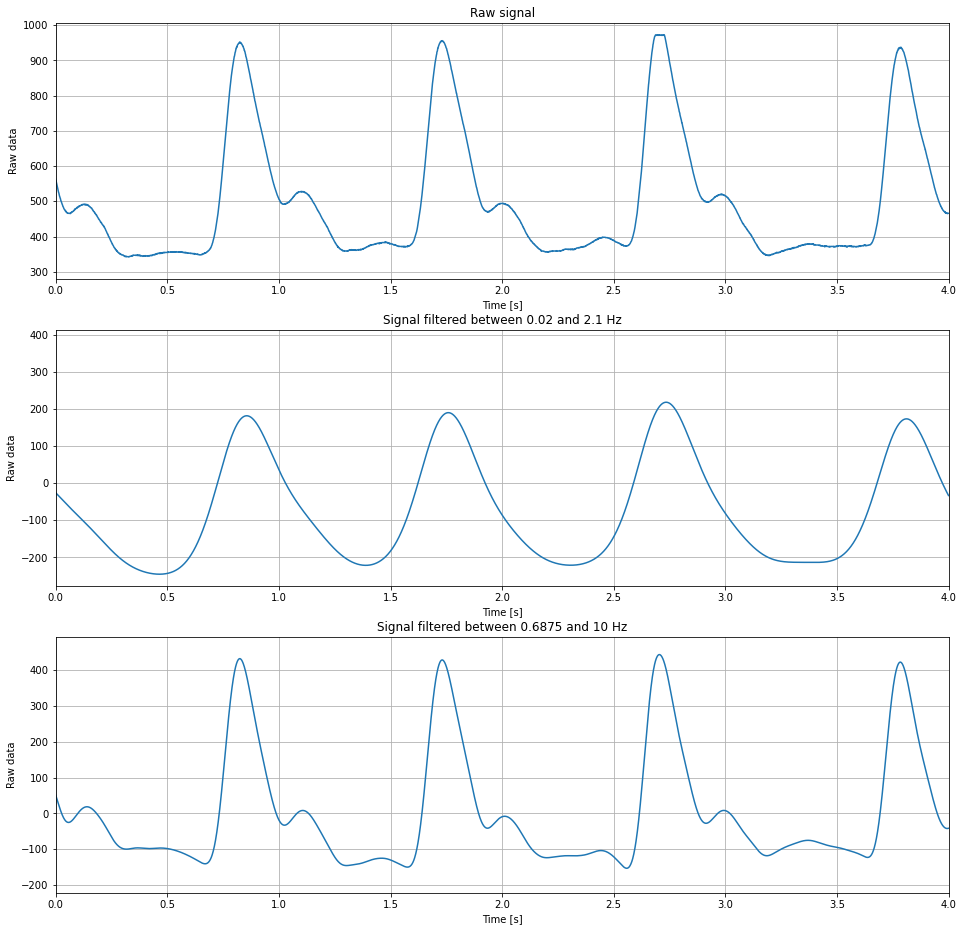

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,16))
ax1.plot(time_BPM, signal_BPM)
ax1.set_title('Raw signal')
ax1.set_xlim([0, 4])
ax1.set_ylabel('Raw data')
ax1.set_xlabel('Time [s]')
ax1.grid()
ax2.plot(time_BPM, signal_res)
ax2.set_title('Signal filtered between 0.02 and 2.1 Hz')
ax2.set_xlim([0, 4])
ax2.set_ylabel('Raw data')
ax2.set_xlabel('Time [s]')
ax2.grid()
ax3.plot(time_BPM, signal_ext)
ax3.set_title('Signal filtered between 0.6875 and 10 Hz')
ax3.set_xlim([0, 4])
ax3.set_ylabel('Raw data')
ax3.set_xlabel('Time [s]')
ax3.grid()

- The restrictive filtered signal ( signal_res ) generates an excessive smoothed signal, causing lost of information, namely the dicrotic notch
- The extended filtered signal ( signal_ext ) was successful in smoothing the signal but the highlighted artifacts and hand movement oscillations were kept

## Electro Dermal Activity (EDA)

Electrodermal activity (EDA), sometimes known as galvanic skin response (GSR) or skin conductance (SC), is a general term for the measurement of the continuous changes in the electrical conductance properties of the skin in response to sweat secretion by the eccrine sweat glands. Both EDA and sudomotor activity are autonomously modulated by the activity of the sympathetic nervous system (SNS), a component of the autonomic nervous system (ANS), which is involved in the control of involuntary bodily functions, as well as cognitive and emotional states.

1. Connect the EDA sensor to A1
2. Attach the sensor to the body as shown in the figure

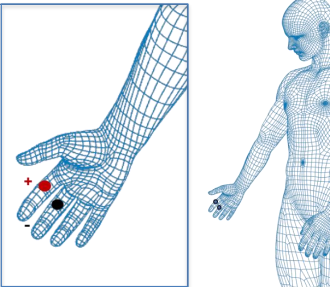

repeat the points of the experiment on the PZT starting at point 2.

### Data analysis

Import the recorded signal by entering the absolute path.

In [31]:
file_path = "C://Users//smarocco.inst//Desktop//SUPSI//WORK//LAB BioSgn//EDA.h5"
h5_object_EDA = File(file_path)

In [32]:
# Keys list (.h5 hierarchy ground level)
print(list(h5_object_EDA.keys()))

['84:BA:20:AE:BC:90']


In [33]:
h5_group_EDA = h5_object_EDA.get('84:BA:20:AE:BC:90')
print ("Second hierarchy level: " + str(list(h5_group_EDA)))

Second hierarchy level: ['digital', 'events', 'plugin', 'raw', 'support']


In [34]:
print ("Second hierarchy level: " + str(list(h5_group_EDA)))

Second hierarchy level: ['digital', 'events', 'plugin', 'raw', 'support']


In [35]:
sampling_rate_EDA = h5_group_EDA.attrs.get("sampling rate")
print ("Sampling Rate: " + str(sampling_rate_EDA))
Resolution = h5_group.attrs.get("resolution")
Resolution[6]

Sampling Rate: 1000


10

In [36]:
h5_sub_group_EDA = h5_group_EDA.get("raw")
print("Third hierarchy level: " + str(list(h5_sub_group_EDA)))

Third hierarchy level: ['channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'nSeq']


From here the recorded data for each sensor channel can be accessed. In our case we will use the data recorded on channel 1.

In [37]:
h5_data_EDA = h5_sub_group_EDA.get("channel_1")
signal_EDA = [item for sublist in h5_data_EDA for item in sublist]
time_EDA = bsnb.generate_time(signal_EDA, sampling_rate_EDA)

Plot the raw data 

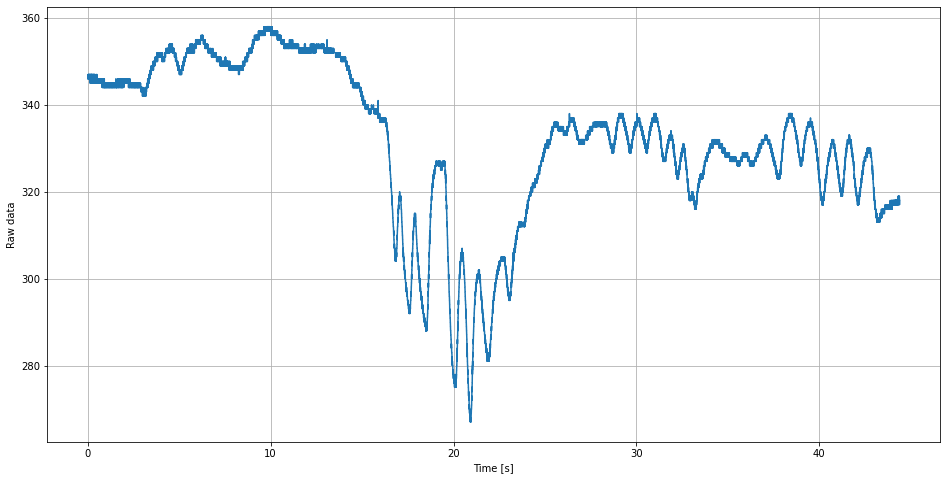

In [38]:
plt.figure(figsize=(16, 8))
plt.plot(time_EDA, signal_EDA)
plt.ylabel("Raw data")
plt.xlabel("Time [s]")
plt.grid()

From the datasheet function convert raw data to have values expressed in microsiemens. 

$$ EMG(\mu S) = \frac{(\frac{ADC}{2^n}) \cdot VCC}{G}$$
Where
- VCC = 3V
- G = 0.12
- ADC = Value sampled from the channel
- n = Number of bits of the channel

In [39]:
Vcc = 3
Gain = 0.12
signal_us = ((np.array(signal_EDA) / 2**Resolution[6]) * Vcc) / Gain

In [40]:
time_us = bsnb.generate_time(signal_us, sampling_rate)

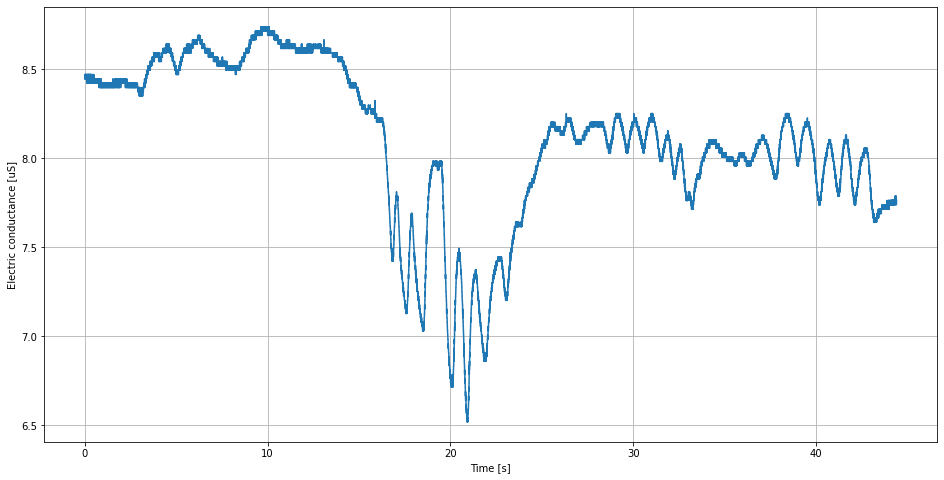

In [41]:
plt.figure(figsize=(16, 8))
plt.plot(time_us, signal_us)
plt.ylabel("Electric conductance [uS]")
plt.xlabel("Time [s]")
plt.grid()

From the plot, it can be seen how quantisation degrades the signal to a 'stepped' form. 

Using a Butterworth bandpass filter it is possible to attenuate all signal components outside the typical EDA frequency bands and to smooth the signal.
To compare the influence of multiple filter bandpass frequencies it will be analysed a restrictive range - [0.045; 0.25] Hz - and a more extended option - [0; 35] Hz.

The Butterworth band-pass filter is defined as follows:

In [42]:
def butter_bandpass_filter(data, cutoff_L, cutoff_H, fs, order):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = [cutoff_L / nyq, cutoff_H / nyq]
    # Get the filter coefficients 
    b, a = signal.butter(order, normal_cutoff, btype='bandpass', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

Set the filter with the above two bands

In [43]:
filt_1 = butter_bandpass_filter(signal_us, 0.045, 0.25, sampling_rate, 2)
filt_2 = butter_bandpass_filter(signal_us, 0.01, 35, sampling_rate, 2)

Plot two graphs for the signals obatined

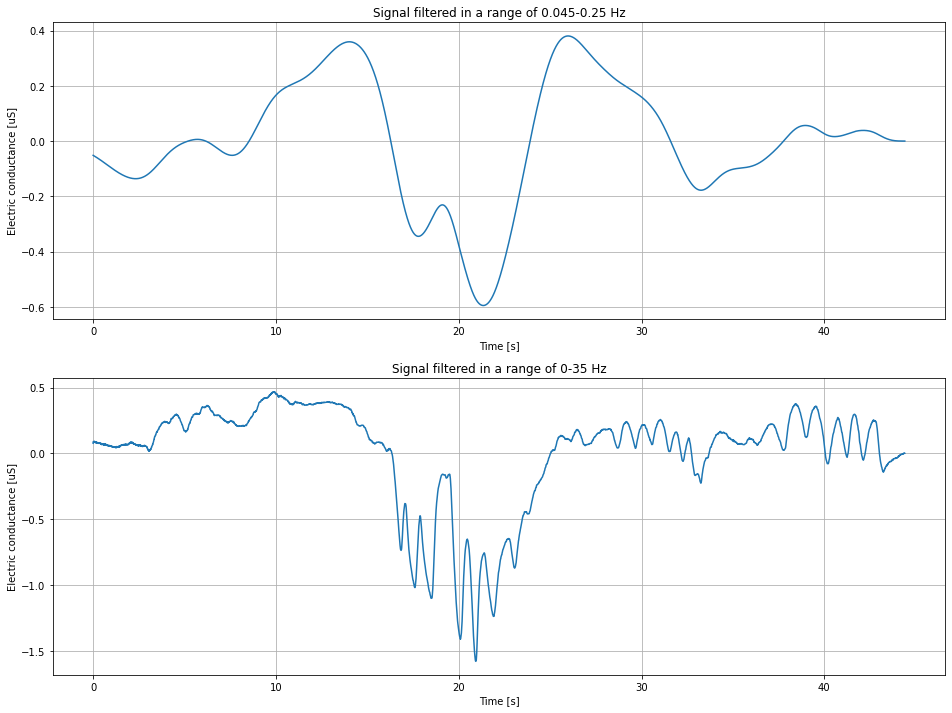

In [44]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))
ax1.plot(time_us, filt_1)
ax1.set_title('Signal filtered in a range of 0.045-0.25 Hz')
ax1.set_ylabel("Electric conductance [uS]")
ax1.set_xlabel("Time [s]")
ax1.grid()
ax2.plot(time_us, filt_2)
ax2.set_title('Signal filtered in a range of 0-35 Hz')
ax2.set_ylabel("Electric conductance [uS]")
ax2.set_xlabel("Time [s]")
ax2.grid()

As can be seen, both filters provide a smoother signal, but the first, more stringent filter degenerates the signal too much. Using a less stringent filter we have a result that is much more faithful to the original signal, while still removing the problem of quantisation. 